In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import pearsonr
from scipy.spatial import distance
from matplotlib import style 
from collections import defaultdict
style.use('default')

# nltk libraries and sources
import nltk
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk import pos_tag
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

import sys
sys.path.append('../')
import utils
import preprocessing

[nltk_data] Downloading package wordnet to /Users/myra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/myra/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/myra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/myra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/myra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/myra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/myra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/myra/nltk_data...
[nltk_data]   Pack

In [3]:
data_root_folder = "../data/"
stopwords_en = set(stopwords.words('english'))

# Read data

In [4]:
data_train, data_dev = utils.load_data(data_root_folder)
articles = utils.load_articles()
# lower textual data
data_train['essay'] = data_train['essay'].apply(lambda x: x.lower())
articles['text'] = articles['text'].apply(lambda x: x.lower())

# tokenized version of the text
data_train = preprocessing.tokenize_data(data_train, 'essay')
articles = preprocessing.tokenize_data(articles, 'text')

# word lematizing
data_train = preprocessing.lemmatize_data(data_train, 'essay_tok')
articles = preprocessing.lemmatize_data(articles, 'text_tok')

In [5]:
empathy_lex, distress_lex = utils.load_empathy_distress_lexicon(data_root_folder="../data/")

# Analysis of PCA for empathy / distress dim

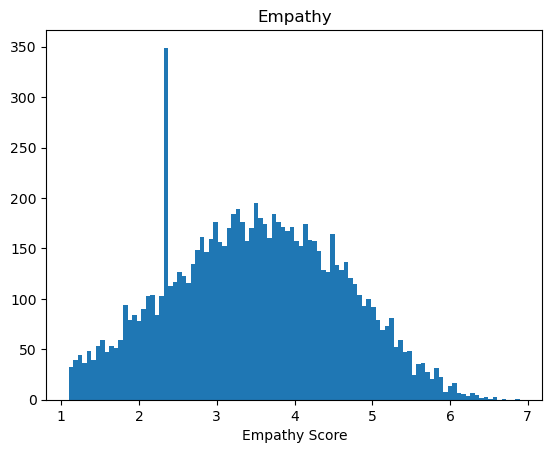

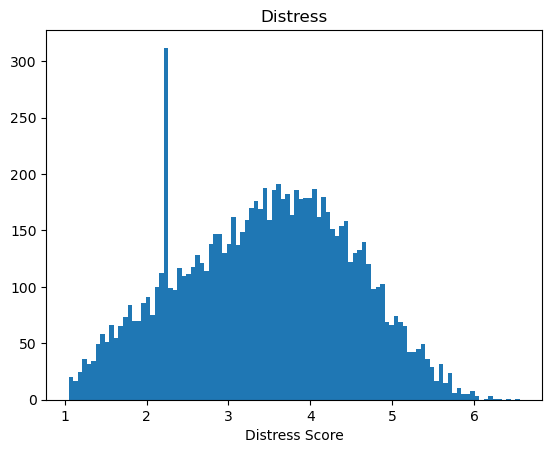

In [6]:
values = list(empathy_lex.values())
plt.hist(values, bins = 100)
plt.xlabel('Empathy Score')
plt.title('Empathy')
plt.show()

values = list(distress_lex.values())
plt.hist(values, bins = 100)
plt.xlabel('Distress Score')
plt.title('Distress')
plt.show()

In [7]:
print('\nEmpathy min scores')
sorted_empathy_dict_min = sorted(empathy_lex.items(), key=lambda item: item[1])
print(sorted_empathy_dict_min[:20])

print('\nEmpathy max scores')
sorted_empathy_dict_max = [(word, score) for word, score in sorted(empathy_lex.items(), key=lambda item: item[1], reverse=True)]
print(sorted_empathy_dict_max[:20])

print('\nDistress min scores')
sorted_distress_dict_min = [(word, score) for word, score in sorted(distress_lex.items(), key=lambda item: item[1])]
print(sorted_distress_dict_min[:20])

print('\nDistress max scores')
sorted_distress_dict_max = [(word, score) for word, score in sorted(distress_lex.items(), key=lambda item: item[1], reverse=True)]
print(sorted_distress_dict_max[:20])


Empathy min scores
[('joke', 1.09719309808247), ('worrying', 1.09822604212761), ('wacky', 1.09834762838549), ('bizarre', 1.09899483576479), ('stupidest', 1.10055367715272), ('pretending', 1.10592706513712), ('amusing', 1.1075202677636), ('fart', 1.10835499265131), ('fool', 1.10935816166989), ('gag', 1.11046663620353), ('except', 1.11331137250805), ('trades', 1.11520438106863), ('fake', 1.11851354344769), ('clown', 1.12048360110033), ('pretended', 1.12538681842619), ('bother', 1.12801179613834), ('dishonest', 1.12949620687347), ('anet', 1.12973836640722), ('slightest', 1.13014492297517), ('either', 1.13167908373534)]

Empathy max scores
[('lukemia', 6.89719309808247), ('lakota', 6.70043879862207), ('healing', 6.59682135519217), ('gaza', 6.59396010702993), ('barakat', 6.55846078878426), ('grieve', 6.5014269631434), ('dubose', 6.43950677509016), ('zambia', 6.43938359567666), ('duckworth', 6.43804711087136), ('heartbreaks', 6.43290793350761), ('shipwrecks', 6.42217383922169), ('empathize'

In [8]:
from nltk.stem import *
from nltk.stem.porter import *

def stem_words(words):
    """Stem words, capable of handling different types. words can either be
    of type str
    or type list(str)
    or type list((str, score))
    where the str object will be stemmed

    Args:
        words (list((str, float)) or list(str) or str): The words as described above

    Returns:
        list((str, float)) or list(str) or str: The stemmed words, returned in the same type as the input type
    """
    # words -> list of words
    # or words -> liste of tuples (list(str, float))
    # or words -> str
    stemmer = PorterStemmer()
    if isinstance(words, list):
        if isinstance(words[0], tuple):
            word_stems = [(stemmer.stem(w), score) for (w, score) in words]
        elif isinstance(words[0], str):
            word_stems = [stemmer.stem(w) for w in words]
        else:
            print('MyWarning in stem_words(): variable "words" should be a list of strings or list of tuples. Returning empty list.')
            word_stems = []
    elif isinstance(words, str):
        word_stems = stemmer.stem(words)
    else:
        print('MyWarning in stem_words(): variable "words" should be a list of strings or list of tuples. Returning empty list.')
        word_stems = []
    return word_stems


def remove_dublicates(words, sorting='max'):
    """Remove dublikates from a (sorted) list.

    Args:
        words (list((str, float)) or list(str)): The list of words
        sorting (str, optional): The sorting mechanism. Defaults to 'max'.

    Returns:
        _type_: _description_
    """
    # words -> liste of tuples (list(str, float))
    # the way to sort the scores (item[1])
    distinct_words = []
    if isinstance(words, list):
        if isinstance(words[0], tuple):
            # sort to make sure, we are returning the word with the highest/lowest value
            reverse = True if sorting=='max' else False
            sorted_words = [(word, score) for word, score in sorted(words, key=lambda item: item[1], reverse=reverse)]
            set_words = list(set([word for word, score in sorted_words]))
            for word, score in sorted_words:
                if word in set_words:
                    set_words.remove(word)
                    distinct_words.append((word, score))
        if isinstance(words[0], str):
            reverse = True if sorting=='max' else False
            set_words = list(set([word for word in words]))
            for word in words:
                if word in set_words:
                    set_words.remove(word)
                    distinct_words.append((word))

    return distinct_words


def get_verbs(words, blacklist=[]):
    """Get the words from a list

    Args:
        words (list((str, float)) or list(str)): The list of words

    Returns:
        list((str, float)) or list(str): The verbs
    """
    verbs = []
    if isinstance(words, list):
        if isinstance(words[0], tuple):
            for word, score in words:
                if word not in blacklist:
                    verb_synset_ls = wn.synsets(word, pos=wn.VERB)  # if a verb can be found in the list
                    if len(verb_synset_ls) >= 1:
                        #print(f'{word} is a verb (score: {score})\n Synset: {verb_synset_ls}\n')
                        verbs.append((word, score))
        if isinstance(words[0], str):
            for word in words:
                if word not in blacklist:
                    verb_synset_ls = wn.synsets(word, pos=wn.VERB)
                    if len(verb_synset_ls) >= 1:
                        verbs.append(word)

    return verbs

def select_words(lexicon, word_count):
    # return min and max sorted words with length of word_count
    blacklist = ['blanket', 'home', 'shipwreck', 'cub']
    def __get_words(sorting):
        reverse = True if sorting=='max' else False
        words_sorted = [(word, score) for word, score in sorted(lexicon.items(), key=lambda item: item[1], reverse=reverse)]
        word_stems = stem_words(words_sorted)
        distinct_word_stems = remove_dublicates(word_stems, sorting=sorting)
        distinct_verbs = get_verbs(distinct_word_stems, blacklist=blacklist)
        return distinct_verbs[:word_count]
    words_min = __get_words(sorting='min')
    words_max = __get_words(sorting='max')
    return words_min, words_max

dis_min, dis_max = select_words(distress_lex, 10)
print('dis_min:\n', dis_min)
print('dis_max:\n', dis_max)
emp_min, emp_max = select_words(empathy_lex, 10)
print('emp_min:\n', emp_min)
print('emp_max:\n', emp_max)

# TODO: Maybe look at lemmas in wordnet and see if one of them is a verb, if yes, take that. If not, don't take it
# for example blankets is not a verb in the lexicon with totally different meaning, but if we stem it and then do verb -> it is a verb but score is for a word with a totally different mean
# if nothing works, just manualy exlcude them

dis_min:
 [('guess', 1.05549069686362), ('hack', 1.05883270118414), ('chime', 1.06075113799987), ('interest', 1.07468670487951), ('except', 1.09226115405961), ('sort', 1.10965570859975), ('reason', 1.13866035355703), ('well', 1.14269635205938), ('stuff', 1.14522945508256), ('use', 1.16195525391104)]
dis_max:
 [('mistreat', 6.31178414562011), ('malnourish', 6.01796802838039), ('assault', 6.01273732117985), ('distress', 6.00846699078174), ('kill', 5.95793654260942), ('screech', 5.9534384145839), ('murder', 5.91287890035859), ('compass', 5.87626312442102), ('rape', 5.8375670680054), ('slaughter', 5.83686787143775)]
emp_min:
 [('joke', 1.09719309808247), ('pretend', 1.10592706513712), ('fart', 1.10835499265131), ('fool', 1.10935816166989), ('gag', 1.11046663620353), ('except', 1.11331137250805), ('trade', 1.11520438106863), ('fake', 1.11851354344769), ('clown', 1.12048360110033), ('bother', 1.12801179613834)]
emp_max:
 [('heal', 6.59682135519217), ('sorrow', 6.29975746152872), ('wound', 6.

In [9]:
import json
pca_df = pd.read_csv('../empdim_settings.csv')
pca_df = pca_df.fillna(value={'notes':'all_random'})
pca_df

,Unnamed: 0,timestamp,dim,task_name,data_lim,vocab_size,princip_comp,pca_var,pca_pearsonr,pca_pearsonp,vocab_min,vocab_min_scores,vocab_max,vocab_max_scores,random_vocab,id,notes
0,0,1.653907e+09,3,distress,5000,10,0,0.308225,0.310848,3.108476e-01,guess;hack;chime;interest;except;sort;reason;w...,1.05549069686362;1.05883270118414;1.0607511379...,mistreat;malnourish;assault;distress;kill;scre...,6.31178414562011;6.01796802838039;6.0127373211...,NaN,NaN,all_random
1,1,1.653907e+09,3,distress,5000,10,1,0.131439,0.034156,3.415578e-02,guess;hack;chime;interest;except;sort;reason;w...,1.05549069686362;1.05883270118414;1.0607511379...,mistreat;malnourish;assault;distress;kill;scre...,6.31178414562011;6.01796802838039;6.0127373211...,NaN,NaN,all_random
2,2,1.653907e+09,3,distress,5000,10,2,0.101153,-0.023681,-2.368073e-02,guess;hack;chime;interest;except;sort;reason;w...,1.05549069686362;1.05883270118414;1.0607511379...,mistreat;malnourish;assault;distress;kill;scre...,6.31178414562011;6.01796802838039;6.0127373211...,NaN,NaN,all_random
3,0,1.653907e+09,3,empathy,5000,10,0,0.216995,0.097751,9.775092e-02,joke;pretend;fart;fool;gag;except;trade;fake;c...,1.09719309808247;1.10592706513712;1.1083549926...,heal;sorrow;wound;scar;suffer;blister;journey;...,6.59682135519217;6.29975746152872;6.2680029787...,NaN,NaN,all_random
4,1,1.653907e+09,3,empathy,5000,10,1,0.165844,0.240154,2.401541e-01,joke;pretend;fart;fool;gag;except;trade;fake;c...,1.09719309808247;1.10592706513712;1.1083549926...,heal;sorrow;wound;scar;suffer;blister;journey;...,6.59682135519217;6.29975746152872;6.2680029787...,NaN,NaN,all_random
5,2,1.653907e+09,3,empathy,5000,10,2,0.089726,0.043779,4.377896e-02,joke;pretend;fart;fool;gag;except;trade;fake;c...,1.09719309808247;1.10592706513712;1.1083549926...,heal;sorrow;wound;scar;suffer;blister;journey;...,6.59682135519217;6.29975746152872;6.2680029787...,NaN,NaN,all_random
6,0,1.653907e+09,3,distress,5000,20,0,0.265653,-0.298622,-2.986224e-01,guess;hack;chime;interest;except;sort;reason;w...,1.05549069686362;1.05883270118414;1.0607511379...,mistreat;malnourish;assault;distress;kill;scre...,6.31178414562011;6.01796802838039;6.0127373211...,NaN,NaN,all_random
7,1,1.653907e+09,3,distress,5000,20,1,0.124679,-0.016770,-1.677013e-02,guess;hack;chime;interest;except;sort;reason;w...,1.05549069686362;1.05883270118414;1.0607511379...,mistreat;malnourish;assault;distress;kill;scre...,6.31178414562011;6.01796802838039;6.0127373211...,NaN,NaN,all_random
8,2,1.653907e+09,3,distress,5000,20,2,0.085372,0.012068,1.206792e-02,guess;hack;chime;interest;except;sort;reason;w...,1.05549069686362;1.05883270118414;1.0607511379...,mistreat;malnourish;assault;distress;kill;scre...,6.31178414562011;6.01796802838039;6.0127373211...,NaN,NaN,all_random
9,0,1.653908e+09,3,empathy,5000,20,0,0.217219,0.143312,1.433125e-01,joke;pretend;fart;fool;gag;except;trade;fake;c...,1.09719309808247;1.10592706513712;1.1083549926...,heal;sorrow;wound;scar;suffer;blister;journey;...,6.59682135519217;6.29975746152872;6.2680029787...,NaN,NaN,all_random


In [10]:

# for each run get the principal component with the higest pearson_r
idx = pca_df.groupby(['timestamp', 'notes'])['pca_pearsonr'].transform(lambda x: max(np.abs(x))) == np.abs(pca_df['pca_pearsonr'])
pca_df[idx]

,Unnamed: 0,timestamp,dim,task_name,data_lim,vocab_size,princip_comp,pca_var,pca_pearsonr,pca_pearsonp,vocab_min,vocab_min_scores,vocab_max,vocab_max_scores,random_vocab,id,notes
0,0,1.653907e+09,3,distress,5000,10,0,0.308225,0.310848,3.108476e-01,guess;hack;chime;interest;except;sort;reason;w...,1.05549069686362;1.05883270118414;1.0607511379...,mistreat;malnourish;assault;distress;kill;scre...,6.31178414562011;6.01796802838039;6.0127373211...,NaN,NaN,all_random
4,1,1.653907e+09,3,empathy,5000,10,1,0.165844,0.240154,2.401541e-01,joke;pretend;fart;fool;gag;except;trade;fake;c...,1.09719309808247;1.10592706513712;1.1083549926...,heal;sorrow;wound;scar;suffer;blister;journey;...,6.59682135519217;6.29975746152872;6.2680029787...,NaN,NaN,all_random
6,0,1.653907e+09,3,distress,5000,20,0,0.265653,-0.298622,-2.986224e-01,guess;hack;chime;interest;except;sort;reason;w...,1.05549069686362;1.05883270118414;1.0607511379...,mistreat;malnourish;assault;distress;kill;scre...,6.31178414562011;6.01796802838039;6.0127373211...,NaN,NaN,all_random
10,1,1.653908e+09,3,empathy,5000,20,1,0.103890,-0.240318,-2.403182e-01,joke;pretend;fart;fool;gag;except;trade;fake;c...,1.09719309808247;1.10592706513712;1.1083549926...,heal;sorrow;wound;scar;suffer;blister;journey;...,6.59682135519217;6.29975746152872;6.2680029787...,NaN,NaN,all_random
12,0,1.653909e+09,3,distress,5000,5,0,0.293861,0.297622,2.976222e-01,guess;hack;chime;interest;except,1.05549069686362;1.05883270118414;1.0607511379...,mistreat;malnourish;assault;distress;kill,6.31178414562011;6.01796802838039;6.0127373211...,NaN,NaN,all_random
16,1,1.653910e+09,3,empathy,5000,5,1,0.269352,0.267865,2.678650e-01,joke;pretend;fart;fool;gag,1.09719309808247;1.10592706513712;1.1083549926...,heal;sorrow;wound;scar;suffer,6.59682135519217;6.29975746152872;6.2680029787...,NaN,NaN,all_random
19,1,1.653915e+09,3,distress,5000,10,1,0.118135,0.217421,1.434631e-54,wave;touch;foster;drown;storm;ingrain;sold;lea...,3.72751650284919;3.28217838694426;5.1189388027...,bead;shoot;till;brief;bark;alert;ice;rough;acc...,3.44417044164956;5.56898058912823;2.9259722435...,True,NaN,all_random
22,1,1.653915e+09,3,empathy,5000,10,1,0.113040,0.189819,8.813863e-42,bit;climb;vomit;keep;firm;lead;fled;queen;eye;...,1.37556328364755;3.70043941143615;3.7039790447...,grip;flaw;fault;hail;quarter;japanes;core;weep...,3.47471336542806;2.34587367164315;2.6896357093...,True,NaN,all_random
25,1,1.653916e+09,3,empathy,5000,10,1,0.148520,-0.191131,2.395682e-42,pretend;fool;except;trade;fake;bother;annoy;em...,1.10592706513712;1.10935816166989;1.1133113725...,heal;sorrow;wound;scar;suffer;blister;journey;...,6.59682135519217;6.29975746152872;6.2680029787...,False,NaN,all_random
27,0,1.000000e+00,3,distress,5000,10,0,0.308225,0.310848,1.870319e-112,guess;hack;chime;interest;except;sort;reason;w...,1.05549069686362;1.05883270118414;1.0607511379...,mistreat;malnourish;assault;distress;kill;scre...,6.31178414562011;6.01796802838039;6.0127373211...,False,1.653994e+09,all_random


In [11]:
# for each run get the principal component with the higest pearson_r
idx = pca_df.groupby('timestamp')['pca_var'].transform(lambda x: max(x)) == np.abs(pca_df['pca_var'])
pca_df[idx]

,Unnamed: 0,timestamp,dim,task_name,data_lim,vocab_size,princip_comp,pca_var,pca_pearsonr,pca_pearsonp,vocab_min,vocab_min_scores,vocab_max,vocab_max_scores,random_vocab,id,notes
0,0,1.653907e+09,3,distress,5000,10,0,0.308225,0.310848,3.108476e-01,guess;hack;chime;interest;except;sort;reason;w...,1.05549069686362;1.05883270118414;1.0607511379...,mistreat;malnourish;assault;distress;kill;scre...,6.31178414562011;6.01796802838039;6.0127373211...,NaN,NaN,all_random
3,0,1.653907e+09,3,empathy,5000,10,0,0.216995,0.097751,9.775092e-02,joke;pretend;fart;fool;gag;except;trade;fake;c...,1.09719309808247;1.10592706513712;1.1083549926...,heal;sorrow;wound;scar;suffer;blister;journey;...,6.59682135519217;6.29975746152872;6.2680029787...,NaN,NaN,all_random
6,0,1.653907e+09,3,distress,5000,20,0,0.265653,-0.298622,-2.986224e-01,guess;hack;chime;interest;except;sort;reason;w...,1.05549069686362;1.05883270118414;1.0607511379...,mistreat;malnourish;assault;distress;kill;scre...,6.31178414562011;6.01796802838039;6.0127373211...,NaN,NaN,all_random
9,0,1.653908e+09,3,empathy,5000,20,0,0.217219,0.143312,1.433125e-01,joke;pretend;fart;fool;gag;except;trade;fake;c...,1.09719309808247;1.10592706513712;1.1083549926...,heal;sorrow;wound;scar;suffer;blister;journey;...,6.59682135519217;6.29975746152872;6.2680029787...,NaN,NaN,all_random
12,0,1.653909e+09,3,distress,5000,5,0,0.293861,0.297622,2.976222e-01,guess;hack;chime;interest;except,1.05549069686362;1.05883270118414;1.0607511379...,mistreat;malnourish;assault;distress;kill,6.31178414562011;6.01796802838039;6.0127373211...,NaN,NaN,all_random
15,0,1.653910e+09,3,empathy,5000,5,0,0.305984,0.065531,6.553126e-02,joke;pretend;fart;fool;gag,1.09719309808247;1.10592706513712;1.1083549926...,heal;sorrow;wound;scar;suffer,6.59682135519217;6.29975746152872;6.2680029787...,NaN,NaN,all_random
18,0,1.653915e+09,3,distress,5000,10,0,0.192650,0.210451,3.654134e-51,wave;touch;foster;drown;storm;ingrain;sold;lea...,3.72751650284919;3.28217838694426;5.1189388027...,bead;shoot;till;brief;bark;alert;ice;rough;acc...,3.44417044164956;5.56898058912823;2.9259722435...,True,NaN,all_random
21,0,1.653915e+09,3,empathy,5000,10,0,0.204800,-0.131649,8.986176e-21,bit;climb;vomit;keep;firm;lead;fled;queen;eye;...,1.37556328364755;3.70043941143615;3.7039790447...,grip;flaw;fault;hail;quarter;japanes;core;weep...,3.47471336542806;2.34587367164315;2.6896357093...,True,NaN,all_random
24,0,1.653916e+09,3,empathy,5000,10,0,0.216436,0.187736,6.842243e-41,pretend;fool;except;trade;fake;bother;annoy;em...,1.10592706513712;1.10935816166989;1.1133113725...,heal;sorrow;wound;scar;suffer;blister;journey;...,6.59682135519217;6.29975746152872;6.2680029787...,False,NaN,all_random
27,0,1.000000e+00,3,distress,5000,10,0,0.308225,0.310848,1.870319e-112,guess;hack;chime;interest;except;sort;reason;w...,1.05549069686362;1.05883270118414;1.0607511379...,mistreat;malnourish;assault;distress;kill;scre...,6.31178414562011;6.01796802838039;6.0127373211...,False,1.653994e+09,all_random


In [12]:
from nltk import pos_tag

from nltk.corpus import wordnet as wn

word = 'shipwreck'

lemmas = wn.lemmas(word)
verb_synset_ls = wn.synsets(word, pos=wn.VERB)

print('lemmas:', lemmas)
print()
print('verb_synset_ls:', verb_synset_ls)

lemmas: [Lemma('shipwreck.n.01.shipwreck'), Lemma('shipwreck.n.02.shipwreck'), Lemma('shipwreck.n.03.shipwreck'), Lemma('shipwreck.v.01.shipwreck'), Lemma('shipwreck.v.02.shipwreck'), Lemma('shipwreck.v.03.shipwreck'), Lemma('shipwreck.v.04.shipwreck')]

verb_synset_ls: [Synset('shipwreck.v.01'), Synset('shipwreck.v.02'), Synset('shipwreck.v.03'), Synset('shipwreck.v.04')]


# Select words from middle of data set
1. Get 'hard coded' middle
2. get middle based on the values for min / max we chose 

**Question**: Does it lead to better results if we have smaples on the whole range? Not only three clusters

# Select balanced scores from lexicon


Amount of subsampled data: 992


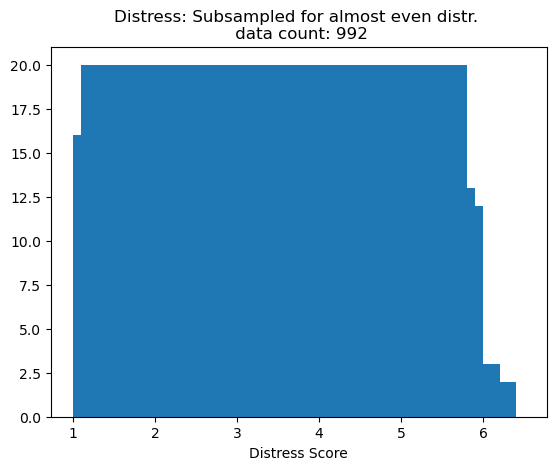

In [164]:
import decimal
import math
import random
random.seed(17)

def subsample_even_score_distr(lexicon, datapoints_per_bin, bin_size, return_binned_data=False, return_bins=False):
    """_summary_

    Args:
        lexicon (_type_): _description_
        datapoints_per_bin (_type_): _description_
        bin_size (_type_): _description_
        return_binned_data (bool, optional): If set to True, the data will be returned as a 
                                    two dimensional list, stored in ther bins. If false, a 
                                    one dimensional list will be returned. Defaults to False.
    """
    # - create list of tuples: list((str, float)) -
    words_sorted = [(word, score) for word, score in sorted(lexicon.items(), key=lambda item: item[1])]

    # - create bins -
    decimal_count = abs(decimal.Decimal(str(bin_size)).as_tuple().exponent)
    min_score = min([item[1] for item in words_sorted])
    max_score = max([item[1] for item in words_sorted])
    bins_start = math.floor(min_score * (10**decimal_count)) / (10**decimal_count)
    bins_end = math.ceil(max_score * (10**decimal_count)) / (10**decimal_count)
    # add the end point to the bins as well, to get the upper range for the elements
    # this will be removed later on, since it is not actually a bin
    bins = np.arange(bins_start, bins_end + bin_size, bin_size)

    # - divide data into bins - 
    binned_data = [[] for i in range(len(bins))]
    for word, score in words_sorted:
        min_idx = np.where(bins <= score)[0]
        max_idx = np.where(bins > score)[0] - 1
        item_bin_idx = np.intersect1d(min_idx, max_idx)[0]
        binned_data[item_bin_idx].append((word, score))
    # remove last bin, because it is 0 anyways, just needed it for the calculation
    binned_data = binned_data[:-1]
    bins = bins[:-1]

    # - shuffle the bins -
    for bin in binned_data:
        random.shuffle(bin)
        
    # - select data points from those bins of size <datapoints_per_bin> -
    binned_data = [bin[:datapoints_per_bin] for bin in binned_data]
    
    if return_binned_data:
        return binned_data if not return_bins else (binned_data, bins)

    unbinned_data = [item for bin in binned_data for item in bin]
    return unbinned_data if not return_bins else (unbinned_data, bins)


subsampled_lex, bins = subsample_even_score_distr(distress_lex, datapoints_per_bin=20, bin_size=0.1, return_bins=True)
print(f'Amount of subsampled data: {len(subsampled_lex)}')
values = list([score for word, score in subsampled_lex])
plt.hist(values, bins=bins)
plt.xlabel('Distress Score')
plt.title(f'Distress: Subsampled for almost even distr. \n data count: {len(values)}')
plt.show()

Amount of subsampled data: 756


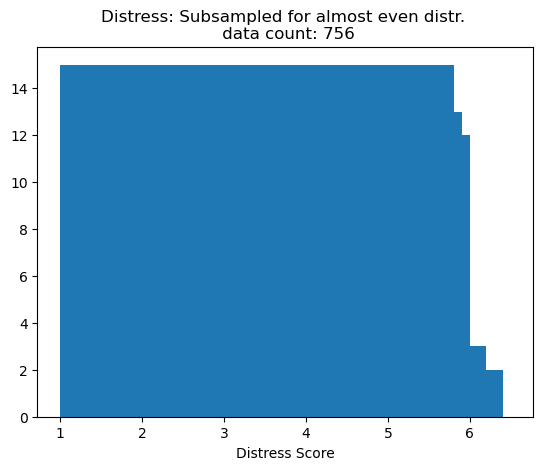

In [162]:

# even less daat points to make it more even
subsampled_lex, bins = subsample_even_score_distr(distress_lex, datapoints_per_bin=15, bin_size=0.1, return_bins=True)
print(f'Amount of subsampled data: {len(subsampled_lex)}')
values = list([score for word, score in subsampled_lex])
plt.hist(values, bins=bins)
plt.xlabel('Distress Score')
plt.title(f'Distress: Subsampled for almost even distr. \n data count: {len(values)}')
plt.show()

### Original histogram of the scores for comparison

Amount of subsampled data: 9356


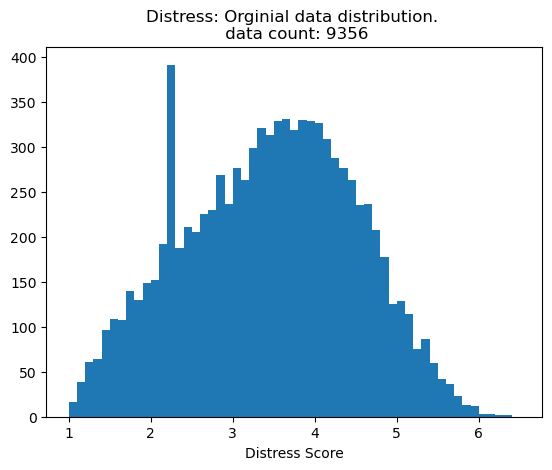

In [117]:
values = list(distress_lex.values())
print(f'Amount of subsampled data: {len(values)}')
plt.hist(values, bins=bins)
plt.xlabel('Distress Score')
plt.title(f'Distress: Orginial data distribution. \n data count: {len(values)}')
plt.show()

In [119]:
input = [('test', 5.5), ('cake', 4.3)]
[(word, score) for word, score in sorted(input, key=lambda item: item[1])]

[('cake', 4.3), ('test', 5.5)]

In [130]:
print('correlate for even subsamples')
even_subsamples = subsample_even_score_distr(distress_lex, datapoints_per_bin=20, bin_size=0.1, return_bins=False)
print(even_subsamples)
sentences_input = [item[0] for item in even_subsamples]
print(sentences_input[:10])
true_labels = [item[1] for item in even_subsamples]
print(true_labels[:10])

correlate for even subsamples
[('anyway', 1.08277352772571), ('except', 1.09226115405961), ('interesting', 1.07468670487951), ('royals', 1.07436453881756), ('probably', 1.08443867950909), ('chime', 1.06075113799987), ('anyhow', 1.07396820553663), ('dumbass', 1.09948164153971), ('dunno', 1.05475101063036), ('though', 1.09154036588725), ('gues', 1.06507779233235), ('somehwere', 1.05334073388562), ('guessing', 1.05549069686362), ('hacks', 1.05883270118414), ('guess', 1.06362592325684), ('anyways', 1.08595603088631), ('somewhere', 1.18201303549918), ('useful', 1.16195525391104), ('stuff', 1.14522945508256), ('lot', 1.19699432403586), ('topic', 1.10499581480693), ('noticeable', 1.10252877053207), ('sort', 1.10965570859975), ('someplace', 1.19320629489321), ('mostly', 1.18107500871089), ('presumably', 1.10911400393333), ('reasonably', 1.13866035355703), ('amusing', 1.18305171561491), ('usually', 1.13557932967659), ('opinion', 1.16903313664206), ('assuming', 1.13759960551522), ('vaguely', 1.1

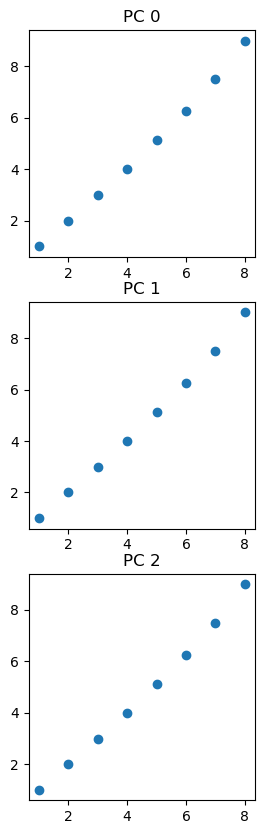

In [146]:
import matplotlib.pyplot as plt

var = np.array([0.3, 0.1, 0.09])
fig, ax = plt.subplots(len(var), figsize=(10,10))
for i in range(len(var)):
    ax[i].scatter([1,2,3,4,5,6,7,8], [1,2,3,4,5.125,6.25,7.5,9])
    ax[i].set_box_aspect(1)
    ax[i].set_title(f'PC {i}')


In [152]:
d = {'a': 1234, 'b': 32423, 'k': 12344}
words = [(key, d[key]) for key in d.keys()]
words

[('a', 1234), ('b', 32423), ('k', 12344)]

In [158]:
random_y = [random.uniform(0, 1) for y in range(len(scores))]
random_y

0.43632507230292483